In [20]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

from matplotlib.pyplot import figure

def group_data(lines: [str]) -> [str]:
    result = {}

    for line in lines:
        parts = line.split(',')
        if parts[0] in result:
            result[parts[0]].append((int(parts[1]), int(parts[2])))
        else:
            result[parts[0]] = [(int(parts[1]), int(parts[2]))]

    return result

geth_evm_go_benchmarks = None
with open("benchmarks-results/geth-evm-go.csv") as f:
    geth_evm_go_benchmarks = group_data(f.readlines())

geth_evm_asm384_benchmarks = None
with open('benchmarks-results/geth-evm-asm384.csv') as f:
    geth_evm_asm384_benchmarks = group_data(f.readlines())

go_arith_benchmarks = None
with open("benchmarks-results/go-arith-benchmarks.csv") as f:
    go_arith_benchmarks = group_data(f.readlines())

print(go_arith_benchmarks.keys())
print("foo")

def scatterplot_ns_data(name: str, annotate: bool, line_of_fit: bool, *args):
    
    x_min_all = min([min([v[0] for v in d]) for (d, _, _) in args])
    x_max_all = max([max([v[0] for v in d]) for (d, _, _) in args])
    y_min_all = min([min([v[1] for v in d]) for (d, _, _) in args])
    y_max_all = max([max([v[1] for v in d]) for (d, _, _) in args])
    span_x = x_max_all - x_min_all
    span_y = y_max_all - y_min_all

    plt.rcParams["figure.figsize"] = (20, 10)
    fig, ax = plt.subplots()
    plt.ylim(0, y_min_all + span_y * 1.2)
    plt.xlim(0, x_min_all + span_x * 1.2)

    if line_of_fit:
        res = np.polyfit(np.array([val[0] for val in args[0][0]]), np.array([val[1] for val in args[0][0]]), 2) # mulmod quadtratic
        print(res)
        print("ok")
        lof_x = [i for i in range(1, len(args[0][0]))]
        lof_y = [x ** 2 * res[0] + x * res[1] + res[2] for x in lof_x]
        print(lof_x)
        print(lof_y)
        print("lof")
        ax.plot(lof_x, lof_y, 'o', color='purple', label="line of fit=...")

    for (data, color, label) in args:
        # Map each onto a scatterplot we'll create with Matplotlib
        #ax.scatter(x=x, y=y, c=scale, s=np.abs(scale)*500)
        mulmont_x = [val[0] for val in data]
        mulmont_y = [val[1] for val in data]

        assert len(mulmont_x) == len(mulmont_y)
        span = max(mulmont_y) - min(mulmont_y)

        plt.xlabel("number of limbs")
        plt.ylabel("runtime (ns)")
        
        if annotate:
            for x, y in zip(mulmont_x, mulmont_y):
                ax.annotate(y, (float(x) + 0.2, float(y)))

        ax.plot(mulmont_x, mulmont_y, 'o', color=color, label=label)
    plt.legend(loc="upper left")
    ax.set(title=name)
    plt.show()

dict_keys(['MulMontAsm', 'AddModAsm', 'SubModAsm', 'MulMontUnrolledGo', 'MulMontNonUnrolledGo', 'AddModUnrolledGo', 'AddModNonUnrolledGo', 'SubModUnrolledGo', 'SubModNonUnrolledGo', 'SetMod', 'MulMontGenericGo'])
foo


depends on:
* https://eips.ethereum.org/EIPS/eip-3690 move jumpdest computation to deployment time: prevents this EIP from having to modify runtime jumpdest analysis
* https://eips.ethereum.org/EIPS/eip-3670 - useful because it introduces EOF containers which serve as a base for 3690, but also introduces rejecting evm code ending with a partial instruction (TODO modify this logic from 3670 in this PR)

## Abstract

This EIP introduces EVMMAX (EVM Modular Arithmetic eXtensions) - a new set of EVM opcodes that provide improved cost vs existing modular arithmetic opcodes, enable performing modular addition/subtraction/multiplication at bit-widths higher than 256bits.

## Motivation

The EVM has `ADDMOD` and `MULMOD` opcodes which perform modular addition and multiplication.  Two inputs and a modulus are passed as stack items and the result is placed on the stack.  Inputs are not required to be less than the modulus.  The EVM word size limits the inputs and modulus to a maximum of 256 bits in size.

For many real-world use-cases, the modulus is odd and fixed for multiple chained arithmetic operations, initial inputs are less than the modulus.  To improve the performance of modular multiplication, values are often expressed in Montgomery form.  This allows for the use of Montgomery modular multiplication which provides improved performance over naive modular multiplication by replacing division by modulus with a bit-shift and conditional single subtraction in the reduction step.

Operating in Montgomery form makes two tradeoffs that are important to consider: inputs must be converted from normal form to Montgomery form and then back again at the end of the computation.  Each conversion requires a single Montgomery reduction per value.  In addition, Montgomery multiplication requires the precomputation of a modulus-specific constant.  This requires a modular inverse which is expensive relative to a single `mulmont`.  However, this upfront cost is amortized by the performance of many modular multiplications.

This EIP lays out a new design to improve on the cost/performance of existing modular arithmetic opcodes in the EVM by introducing a new suite of opcodes which do not take arguments as stack items and introducing an opcode for Montgomery multiplication to overcome the inherent inneficiency of `MULMOD`'s naive modular multiplication.

## Specification

Introduce new opcodes: `SETMODMAX` (0xc)` ADDMODMAX` (0xd), `SUBMODMAX` (0xe), `MULMONTMAX` (0xf) `TOMONTMAX` (0xe)

EVMMAX opcodes operate on values stored in memory.  Values are laid out in little-endian order and 8-byte aligned.  `SETMODMAX` associates a modulus, the configured element size (`limb_count`) and several other computed values dependent on the modulus with the current call context.  Arithmetic opcodes `ADDMODMAX`, `SUBMODMAX`, `MULMONTMAX`, `TOMONTMAX` use the values set by `SETMODMAX`.  Instead of direct offsets, EVMMAX opcodes take 1-byte slot offsets as inputs.  These slot offsets map to contiguous areas of memory:
``` 
def map_slot_to_memory_offset(slot: int, limb_count: int) -> int:
    return slot * limb_count * 8

def value_at_slot(evm_memory: bytes, slot: int, limb_count: int) -> int:
    start_offset = map_slot_to_memory_offset(slot, limb_count)
    end_offset = start_offset + limb_count * 8
    return int.from_bytes(evm_memory[start_offset:end_offset + 1], 'little')
```

`SETMODMAX` takes two stack items as input `<top of stack>, slot, limb_count`. `limb_count` is the number of 8-byte limbs occupied by the modulus.  If the modulus is not odd, `limb_count == 0` or `slot > 255` consume all call gas and return to the calling frame in an exceptional state.  Otherwise, given `mod = value_at_slot(evm_memory, slot, limb_count)` compute the Montgomery constant `mod_inv = pow(-mod, -1, 1 << (limbCount * 64))`, `r_squared = ((1 << (limbCount * 64)) ** 2) % mod` and associate `mod`, `mod_inv`, `r_squared`, `limb_count` with the current EVM call context (overwriting these values if `SETMODMAX` was previously called in the same call context).

Arithmetic opcodes `ADDMODMAX`, `SUBMODMAX` and `MULMONTMAX` each take inputs as 3 1-byte immediate values appended to the opcode.  The opcode layout in the bytecode with the immediates is `{ADDMODMAX_OP/SUBMODMAX_OP/MULMONT_OP}, out_slot, x_slot, y_slot`.

Each arithmetic opcode asserts `SETMODMAX` has previously been called in the same call context and the memory slots which map to the inputs fall within the bounds of allocated memory.  If these conditions are not met, consume all call gas and return to the calling frame in an exceptional state.  Input values referenced by `x_slot`/`y_slot` are loaded from memory.  If they are not less than the modulus, consume all call gas and return to the calling frame in an exceptinal state.  Otherwise, an arithmetic operation is performed, the result is placed in the memory referenced by `out_slot`.

`ADDMODMAX` computes `(value_at_slot(evm_memory, x_slot, callCtx.limb_count) + value_at_slot(evm_memory, y_slot, callCtx.limb_count)) % callCtx.mod`

`SUBMODMAX` computes `(value_at_slot(evm_memory, x_slot, callCtx.limb_count) - value_at_slot(evm_memory, y_slot, callCtx.limb_count)) % callCtx.mod`

`MULMONTMAX` computes `(value_at_slot(evm_memory, x_slot, callCtx.limb_count) * value_at_slot(evm_memory, y_slot, callCtx.limb_count) * pow(1 << (callCtx.limb_count * 64), -1, callCtx.mod)) % callCtx.mod == mulmont(value_at_slot(evm_memory, x_slot, callCtx.limb_count), value_at_slot(evm_memory, y_slot, callCtx.limb_count)`

`TOMONTMAX` takes two stack items as input `<top of stack>, input, output`.  The most significant byte of each input is an EVMMAX slot.  Input loading and validation occurs the same as other arithmetic opcodes.  If inputs are valid, compute `mulmont(input_slot, callCtx.EVMMAX.r_squared)` and place the result in the slot referenced by `output`.

#### Costs

* establish 20ns/gas as a base for cost: runtime of Geth's `MULMOD` arithmetic implementation at 256bit modulus with inputs reduced.
* simple linear model for `ADDMODMAX`/`SUBMODMAX`
* hybrid cost model for `MULMONTMAX`/`TOMONTMAX`: 1 model for low-limb `O(N**2)` mulmont.  separate model after karatsuba threshold `~O(N**1.5)`
* cost of `SETMODMAX` should be the cost of two modular inverses (log(N) complexity with large constant factor?)

## Rationale

* choice of little-endian limbs made to match the hardware of most (all?) Ethereum nodes, removing the need for endianness-swapping individual limbs.

* choice of input encoding as single bytes which map to slots in memory was made to support values of various bit-widths beyond 256bit EVM words.  In addition, it is faster than passing inputs as stack values.
    * restriction to single byte offset is made to reduce contract size footprint while still providing ample potential memory space for EVM crypto implementations.

### Benchmarks

To estimate performance of the arithmetic opcodes, I developed standalone EVM benchmarks which benchmark various opcodes across a range of limb counts using worst-case inputs.  These benchmarks consist of a setup (placing modulus/input values in memory, calling `SETMODMAX`), and a large loop which performs 5000 operations for 255 iterations.

The loop body is composed of invocations of the form `PUSH3 {result offset byte}{x offset byte}{y offset byte} + EVMMAX_ARITH_OP`.

To measure the overhead of `PUSH3`, a separate benchmark which consists of a loop of `PUSH3 000000 POP` with the same number of invocations as the number arithmetic ops in the EVMMAX benchmark.

The runtime of the `PUSH3 POP` benchmark is subtracted from the `EVMMAX OP` benchmark and divided by the number of EVMMAX opcode invocations to estimate a runtime for a given number of limbs.  The cost of the setup is amortized by the main loop of each benchmark.

The below graphs plot the estimated runtime of the EVM opcodes along with performance of standalone arithmetic benchmarks of the same worst-case inputs.  Also included are benchmarks which use the assembly implementation of the arithmetic for 6 limbs from blst.

EVM benchmarks for `SETMODMAX` are omitted because EVM interpreter overhead is insignificant compared to the cost of the arithmetic.


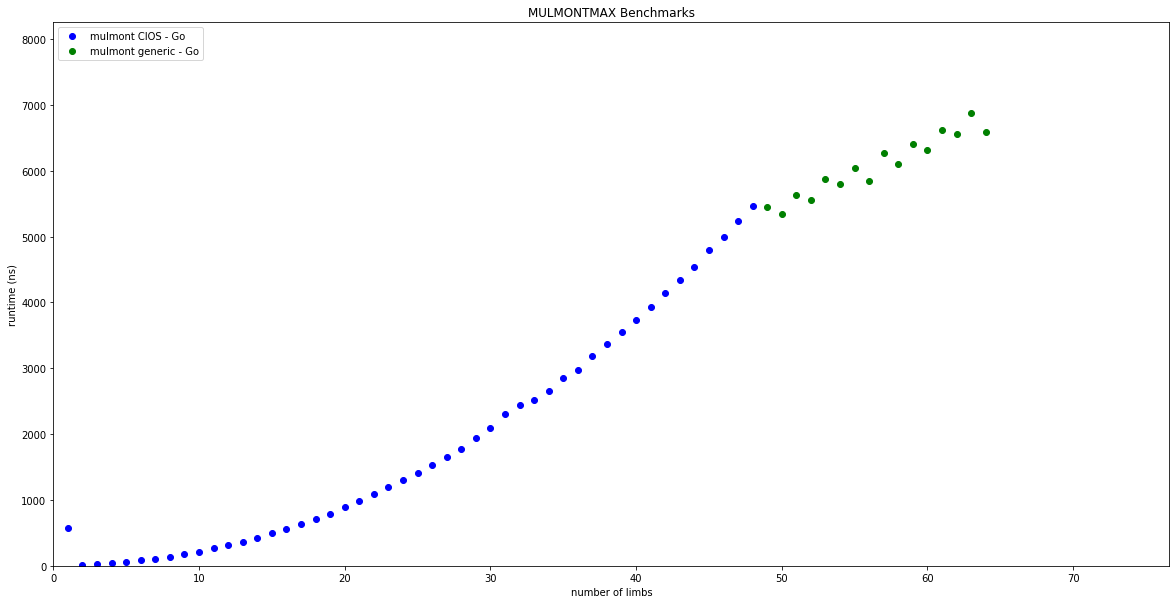

In [21]:
scatterplot_ns_data("MULMONTMAX Benchmarks", False, False, (go_arith_benchmarks['MulMontNonUnrolledGo'][:48], "blue", "mulmont CIOS - Go"),
                                                    (go_arith_benchmarks['MulMontGenericGo'][48:], "green", "mulmont generic - Go"))

def fn():
    scatterplot_ns_data("MulMont Arithmetic Benchmark (blow-up after 11 limbs)", True, False, (go_arith_benchmarks['MulMontGo'], "green", "mulmont arithmetic - Go"))
    scatterplot_ns_data("ADDMODMAX Benchmarks", True, False, (geth_evm_go_benchmarks['ADDMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                        (go_arith_benchmarks['AddModAsm'], "blue", "addmod arithmetic - asm"),
                                                        (go_arith_benchmarks['AddModGo'][:11], "green", "addmod arithmetic - Go"),
                                                        (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "EVM opcode benchmark - asm"))

    scatterplot_ns_data("SUBMODMAX Benchmarks", True, False, (geth_evm_go_benchmarks['SUBMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                        (go_arith_benchmarks['SubModAsm'], "blue", "submod arithmetic - asm"),
                                                        (go_arith_benchmarks['SubModGo'][:11], "green", "submod arithmetic - Go"),
                                                        (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "EVM opcode benchmark - asm"))

    scatterplot_ns_data("SETMOD Benchmarks", True, False, (go_arith_benchmarks['SetMod'], "green", "setmod arithmetic - Go"))

**benchmark note:** these benchmarks were performed on an `i7-6500U CPU @ 2.50GHz` w/ turbo-boost disabled

#### Python Arithmetic Implementation


```
import math

MAX_LIMB_COUNT = 12
LIMB_BITS = 64
WORD_SIZE = 8
LIMB_SIZE = 8
BASE = 1 << 64

# -----------------------------------------------------------------------------
#   start of bignum util code and other helpers
#   numbers are expressed as little-endian lists 64bit unsigned integers

# return x - y (omitting borrow-out)
def limbs_sub(x: [int], y: [int]) -> [int]:
    assert len(x) == len(y), "num_limbs must be equal"
    num_limbs = len(x)
    res = [0] * num_limbs
    c = 0

    for i in range(num_limbs):
        c, res[i] = sub_with_borrow(x[i], y[i], c)

    return res[:]

# given two equally-sized, multiple-limb numbers x, y: return x >= y
def limbs_gte(x, y) -> bool:
    assert len(x) == len(y), "x and y should have same number of limbs"
    
    for (x_limb, y_limb) in reversed(list(zip(x,y))):
        if x_limb > y_limb:
            return True
        elif x_limb < y_limb:
            return False

    return True

# convert an int to a bigint, padding with zero-limbs if limb_count is specified
# and num wouldn't occupy limb_count limbs
def int_to_limbs(num: int, limb_count=None) -> [int]:
    res = []

    if limb_count != None:
        assert num < (1 << (limb_count * LIMB_BITS)), "num must be representable with given limb_count"
        for _ in range(limb_count):
            res.append(num % BASE)
            num //= BASE
    else:
        if num == 0:
            return [0]

        while num != 0:
            if num < BASE:
                res.append(num)
                break

            res.append(num % BASE)
            num //= BASE

    return res

def limbs_to_int(limbs: [int]) -> [int]:
    res = 0
    for i, limb in enumerate(limbs):
        res += limb * (BASE ** i)
    return res

# split a 128bit val into hi/low words
def hi_lo(val128: int) -> (int, int):
    assert val128 < 1 << (LIMB_BITS * 2), "val must fit in two words"
    return (val128 >> LIMB_BITS) % BASE, val128 % BASE

# compute (x - y - b). if negative 1, (x - y - b) % BASE, else return 0, (x - y - b) % BASE
# b (borrow-in) must be 1 or 0
def sub_with_borrow(x: int, y: int, b: int) -> (int, int):
    assert b == 0 or b == 1, "borrow in must be zero or one"

    res = x - y - b
    b_out = 0
    if res < 0:
        res = BASE - abs(res)
        b_out = 1

    return b_out, res

# -----------------------------------------------------------------------------
# start of EVMMAX arithmetic

# implementation adapted from section 2.3.2 in https://www.microsoft.com/en-us/research/wp-content/uploads/1998/06/97Acar.pdf
# mulmont_cios computes (x * y * pow(R, -1, mod)) % mod, where R = 1 << (limb_count * word_size * 8)
# modinv must be pow(-mod, -1, BASE)
def mulmont_cios(x, y, mod, modinv) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "{}, {}, {}".format(x, y, mod)
    assert mod[-1] != 0, "modulus must occupy all limbs"

    limb_count = len(mod)

    t = [0] * (limb_count + 2)

    for i in range(limb_count):
        # first inner-loop multiply x * y[i]
        c = 0 
        for j in range(limb_count):
            c, t[j] = hi_lo(t[j] + x[j] * y[i] + c)

        t[limb_count + 1], t[limb_count] = hi_lo(t[limb_count] + c)

        m = (modinv * t[0]) % BASE
        c, _ = hi_lo(m * mod[0] + t[0])

        # second inner-loop: reduction.
        for j in range(1, limb_count):
            c, t[j - 1] = hi_lo(t[j] + mod[j] * m + c)

        hi, t[limb_count - 1] = hi_lo(t[limb_count] + c)
        t[limb_count] = t[limb_count + 1] + hi

    t = t[:-1]
    if t[-1] != 0:
        return limbs_sub(t, mod + [0])[:-1]
    elif limbs_gte(t[:-1], mod):
        return limbs_sub(t[:-1], mod)
    else:
        return t[:-1]


# addmod computes (x + y) % mod
def addmod(x: [int], y: [int], mod: [int]) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    limb_count = len(mod)
    tmp = [0] * limb_count
    z = [0] * limb_count
    c, c1 = 0, 0

    if limbs_gte(x, mod) or limbs_gte(y, mod):
        raise Exception("x/y must be less than the modulus")

    for i in range(limb_count):
        c, tmp[i] = hi_lo(x[i] + y[i] + c)

    for i in range(limb_count):
        c1, z[i] = sub_with_borrow(tmp[i], mod[i], c1)

    if c == 0 and c1 != 0:
        z[:] = tmp[:]

    return z

# submod computes (x - y) % mod
def submod(x: [int], y: [int], mod: [int]) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    limb_count = len(mod)
    tmp = [0] * limb_count
    z = [0] * limb_count
    c, c1 = 0, 0

    if limbs_gte(x, mod) or limbs_gte(y, mod):
        raise Exception("x/y must be less than the modulus")

    for i in range(limb_count):
        c, tmp[i] = sub_with_borrow(x[i], y[i], c)

    for i in range(limb_count):
        c1, z[i] = hi_lo(tmp[i] + mod[i] + c1)

    if c == 0:
        z[:] = tmp[:]

    return z

# setmod computes a modulus-specific constant used by the CIOS algorithm (and also some other algorithms that operate at small bit-widths)
def setmod(mod: [int]) -> int:
    assert len(mod) > 0 and len(mod) <= MAX_LIMB_COUNT, "modulus must be in correct range"
    result = pow(-limbs_to_int(mod), -1, BASE)
    return result
```

## Backwards Compatibility

There are no backwards-compatibility concerns for the changes introduced in this EIP.

## Test Cases
TODO

## Reference Implementation

Geth implementation: https://github.com/ethereum/go-ethereum/pull/25503

Arithmetic reference implementation written in Python: https://github.com/jwasinger/py-evmmax

## Security Considerations
* TODO

## Other TODOs

* specify behavior when using a slot that would extend beyond the bounds of memory:
1) try to expand memory and fail in this case.
2) treat the out-of-bounds portion as zeros.
3) try to expand memory and fail if the offset is an output AND 2) if it is an input.
